In [1]:
!pip install fastapi uvicorn python-multipart pillow
!pip install tensorflow==2.15.0  # Compatible with Python 3.14

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0


Loading dataset...
Processing riding_a_bike: 293 images
Processing using_a_computer: 230 images
Processing rowing_a_boat: 185 images
Processing applauding: 284 images
Processing cleaning_the_floor: 212 images
Processing riding_a_horse: 296 images
Processing brushing_teeth: 200 images
Processing fixing_a_car: 251 images
Processing phoning: 259 images
Processing cutting_trees: 203 images
Processing looking_through_a_telescope: 203 images
Processing taking_photos: 197 images
Processing writing_on_a_book: 246 images
Processing running: 251 images
Processing cutting_vegetables: 189 images
Processing playing_guitar: 289 images
Processing shooting_an_arrow: 214 images
Processing drinking: 256 images
Processing jumping: 295 images
Processing throwing_frisby: 202 images
Processing gardening: 199 images
Processing pushing_a_cart: 235 images
Processing fishing: 273 images
Processing writing_on_a_board: 183 images
Processing cooking: 288 images
Processing reading: 245 images
Processing texting_mes

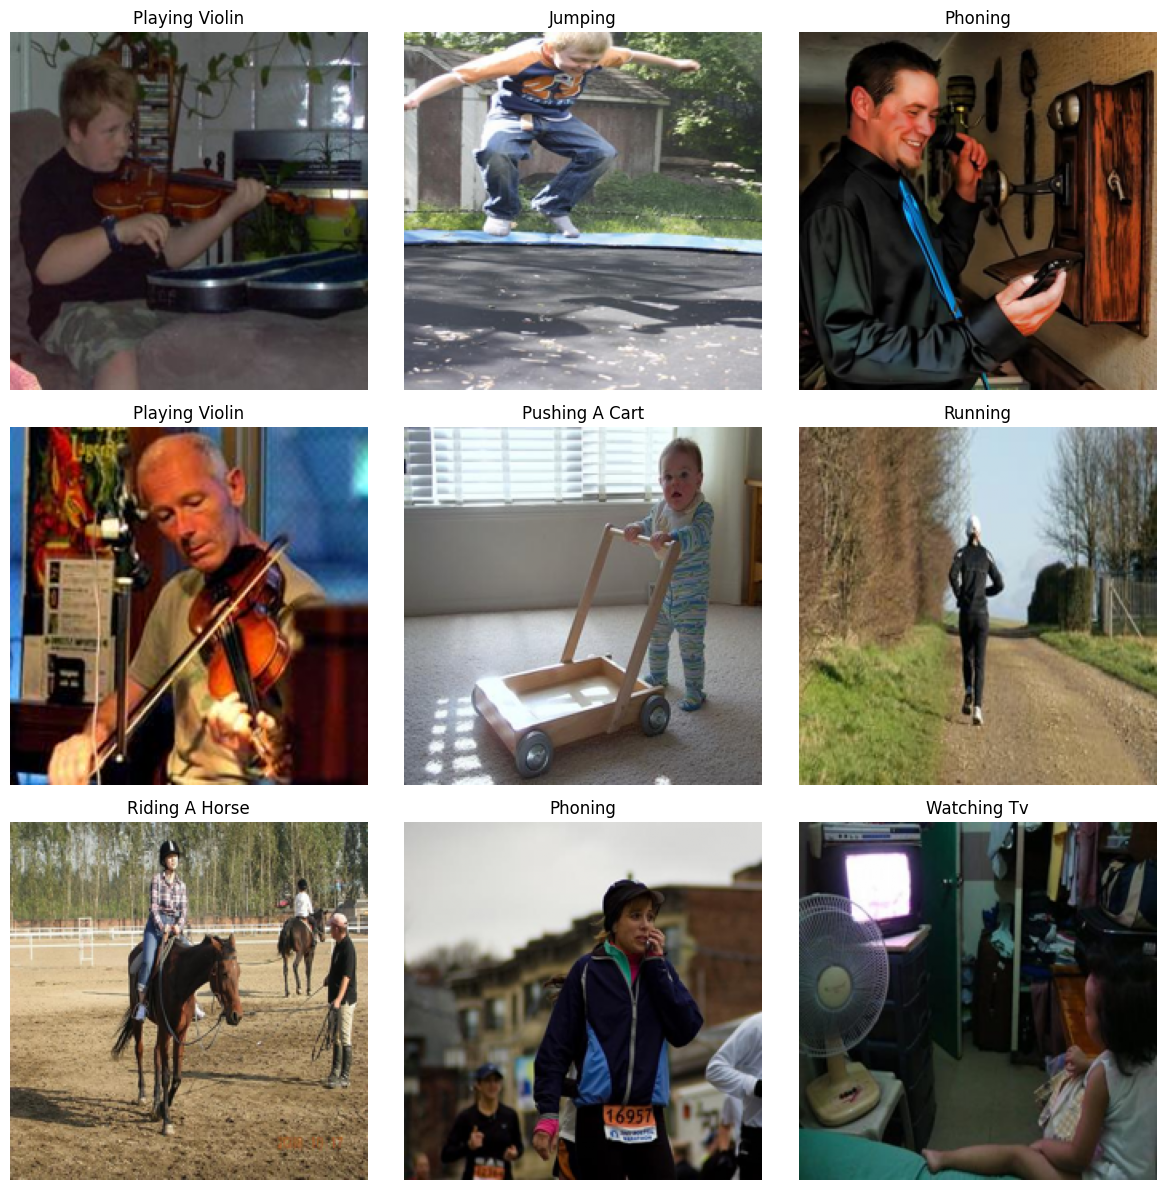


Dataset preprocessing complete!
Metadata saved to: dataset_metadata.json


In [3]:
"""
Stanford 40 Dataset Preprocessing Pipeline
Prepares images and labels for CNN-LSTM training
"""

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json

# Configuration
IMG_HEIGHT = 224
IMG_WIDTH = 224
DATASET_PATH = '/kaggle/input/stanford-40-full'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train_FUll')

class DatasetPreprocessor:
    def __init__(self, dataset_path, img_size=(224, 224)):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.label_encoder = LabelEncoder()
        self.action_to_description = self._create_action_descriptions()
        
    def _create_action_descriptions(self):
        """Create natural language descriptions for each action"""
        descriptions = {
            'applauding': 'A person is clapping hands together in applause',
            'blowing_bubbles': 'A person is blowing soap bubbles',
            'brushing_teeth': 'A person is brushing their teeth with a toothbrush',
            'cleaning_the_floor': 'A person is cleaning the floor',
            'climbing': 'A person is climbing up a surface',
            'cooking': 'A person is preparing or cooking food',
            'cutting_trees': 'A person is cutting down trees with a tool',
            'cutting_vegetables': 'A person is slicing vegetables with a knife',
            'drinking': 'A person is drinking from a container',
            'feeding_a_horse': 'A person is feeding a horse',
            'fishing': 'A person is fishing with a rod',
            'fixing_a_bike': 'A person is repairing a bicycle',
            'fixing_a_car': 'A person is fixing or working on a car',
            'gardening': 'A person is working in a garden',
            'holding_an_umbrella': 'A person is holding an umbrella',
            'jumping': 'A person is jumping in the air',
            'looking_through_a_microscope': 'A person is examining something through a microscope',
            'looking_through_a_telescope': 'A person is observing through a telescope',
            'playing_guitar': 'A person is playing a guitar',
            'playing_violin': 'A person is playing a violin',
            'pouring_liquid': 'A person is pouring liquid from one container to another',
            'pushing_a_cart': 'A person is pushing a shopping cart',
            'reading': 'A person is reading a book or document',
            'phoning': 'A person is talking on a telephone',
            'riding_a_bike': 'A person is riding a bicycle',
            'riding_a_horse': 'A person is riding on a horse',
            'rowing_a_boat': 'A person is rowing a boat',
            'running': 'A person is running at a fast pace',
            'shooting_an_arrow': 'A person is shooting an arrow with a bow',
            'smoking': 'A person is smoking a cigarette',
            'taking_photos': 'A person is taking photographs with a camera',
            'texting_message': 'A person is typing a text message on a phone',
            'throwing_frisby': 'A person is throwing a frisbee',
            'using_a_computer': 'A person is working on a computer',
            'walking_the_dog': 'A person is walking with a dog on a leash',
            'washing_dishes': 'A person is washing dishes at a sink',
            'watching_tv': 'A person is watching television',
            'waving_hands': 'A person is waving their hands',
            'writing_on_a_board': 'A person is writing on a whiteboard or blackboard',
            'writing_on_a_book': 'A person is writing in a book or notebook'
        }
        return descriptions
    
    def load_data(self):
        """Load all images and labels from dataset"""
        images = []
        labels = []
        image_paths = []
        
        print("Loading dataset...")
        action_folders = [f for f in os.listdir(self.dataset_path) 
                         if os.path.isdir(os.path.join(self.dataset_path, f))]
        
        for action in action_folders:
            action_path = os.path.join(self.dataset_path, action)
            if not os.path.isdir(action_path):
                continue
                
            image_files = [f for f in os.listdir(action_path) 
                          if f.endswith(('.jpg', '.jpeg', '.png'))]
            
            print(f"Processing {action}: {len(image_files)} images")
            
            for img_file in image_files:
                img_path = os.path.join(action_path, img_file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(self.img_size)
                    img_array = np.array(img) / 255.0  # Normalize
                    
                    images.append(img_array)
                    labels.append(action)
                    image_paths.append(img_path)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
        
        return np.array(images), np.array(labels), image_paths
    
    def prepare_dataset(self, test_size=0.2, val_size=0.1):
        """Prepare train, validation, and test splits"""
        X, y_labels, paths = self.load_data()
        
        # Encode labels
        y = self.label_encoder.fit_transform(y_labels)
        
        # Split data
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=(test_size + val_size), random_state=42, stratify=y
        )
        
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=(test_size/(test_size + val_size)), 
            random_state=42, stratify=y_temp
        )
        
        print(f"\nDataset split:")
        print(f"Train: {X_train.shape[0]} images")
        print(f"Validation: {X_val.shape[0]} images")
        print(f"Test: {X_test.shape[0]} images")
        print(f"Number of classes: {len(self.label_encoder.classes_)}")
        
        # Save metadata
        metadata = {
            'classes': self.label_encoder.classes_.tolist(),
            'num_classes': len(self.label_encoder.classes_),
            'action_descriptions': self.action_to_description,
            'img_size': self.img_size
        }
        
        with open('dataset_metadata.json', 'w') as f:
            json.dump(metadata, f, indent=2)
        
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), metadata
    
    def visualize_samples(self, X, y, num_samples=9):
        """Visualize random samples from dataset"""
        indices = np.random.choice(len(X), num_samples, replace=False)
        
        fig, axes = plt.subplots(3, 3, figsize=(12, 12))
        axes = axes.ravel()
        
        for i, idx in enumerate(indices):
            axes[i].imshow(X[idx])
            action = self.label_encoder.inverse_transform([y[idx]])[0]
            axes[i].set_title(action.replace('_', ' ').title())
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
        plt.show()


# Usage Example
if __name__ == "__main__":
    preprocessor = DatasetPreprocessor(TRAIN_PATH)
    
    # Load and prepare dataset
    (X_train, y_train), (X_val, y_val), (X_test, y_test), metadata = preprocessor.prepare_dataset()
    
    # Visualize samples
    preprocessor.visualize_samples(X_train, y_train)
    
    # Save processed data (optional - for later use)
    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)
    np.save('X_val.npy', X_val)
    np.save('y_val.npy', y_val)
    np.save('X_test.npy', X_test)
    np.save('y_test.npy', y_test)
    
    print("\nDataset preprocessing complete!")
    print(f"Metadata saved to: dataset_metadata.json")

In [3]:
"""
Memory-Safe Dataset Preprocessing
Uses smaller image size and limits samples per class
"""

import os
import numpy as np
from PIL import Image
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import gc

# REDUCED CONFIGURATION FOR MEMORY
IMG_HEIGHT = 128  # Reduced from 224
IMG_WIDTH = 128   # Reduced from 224
MAX_SAMPLES_PER_CLASS = 150  # Limit samples per class
DATASET_PATH = '/kaggle/input/stanford-40-full/train_FUll'

class MemorySafePreprocessor:
    def __init__(self, dataset_path, img_size=(128, 128), max_per_class=150):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.max_per_class = max_per_class
        self.label_encoder = LabelEncoder()
        self.action_to_description = self._create_action_descriptions()
        
    def _create_action_descriptions(self):
        """Create natural language descriptions for each action"""
        descriptions = {
            'applauding': 'A person is clapping hands together in applause',
            'blowing_bubbles': 'A person is blowing soap bubbles',
            'brushing_teeth': 'A person is brushing their teeth with a toothbrush',
            'cleaning_the_floor': 'A person is cleaning the floor',
            'climbing': 'A person is climbing up a surface',
            'cooking': 'A person is preparing or cooking food',
            'cutting_trees': 'A person is cutting down trees with a tool',
            'cutting_vegetables': 'A person is slicing vegetables with a knife',
            'drinking': 'A person is drinking from a container',
            'feeding_a_horse': 'A person is feeding a horse',
            'fishing': 'A person is fishing with a rod',
            'fixing_a_bike': 'A person is repairing a bicycle',
            'fixing_a_car': 'A person is fixing or working on a car',
            'gardening': 'A person is working in a garden',
            'holding_an_umbrella': 'A person is holding an umbrella',
            'jumping': 'A person is jumping in the air',
            'looking_through_a_microscope': 'A person is examining something through a microscope',
            'looking_through_a_telescope': 'A person is observing through a telescope',
            'playing_guitar': 'A person is playing a guitar',
            'playing_violin': 'A person is playing a violin',
            'pouring_liquid': 'A person is pouring liquid from one container to another',
            'pushing_a_cart': 'A person is pushing a shopping cart',
            'reading': 'A person is reading a book or document',
            'phoning': 'A person is talking on a telephone',
            'riding_a_bike': 'A person is riding a bicycle',
            'riding_a_horse': 'A person is riding on a horse',
            'rowing_a_boat': 'A person is rowing a boat',
            'running': 'A person is running at a fast pace',
            'shooting_an_arrow': 'A person is shooting an arrow with a bow',
            'smoking': 'A person is smoking a cigarette',
            'taking_photos': 'A person is taking photographs with a camera',
            'texting_message': 'A person is typing a text message on a phone',
            'throwing_frisby': 'A person is throwing a frisbee',
            'using_a_computer': 'A person is working on a computer',
            'walking_the_dog': 'A person is walking with a dog on a leash',
            'washing_dishes': 'A person is washing dishes at a sink',
            'watching_tv': 'A person is watching television',
            'waving_hands': 'A person is waving their hands',
            'writing_on_a_board': 'A person is writing on a whiteboard or blackboard',
            'writing_on_a_book': 'A person is writing in a book or notebook'
        }
        return descriptions
    
    def load_data_memory_safe(self):
        """Load dataset with memory constraints"""
        images = []
        labels = []
        
        print("Loading dataset with memory optimization...")
        action_folders = [f for f in os.listdir(self.dataset_path) 
                         if os.path.isdir(os.path.join(self.dataset_path, f))]
        
        for action in sorted(action_folders):
            action_path = os.path.join(self.dataset_path, action)
            if not os.path.isdir(action_path):
                continue
                
            image_files = [f for f in os.listdir(action_path) 
                          if f.endswith(('.jpg', '.jpeg', '.png'))]
            
            # Limit samples per class
            image_files = image_files[:self.max_per_class]
            
            print(f"Processing {action}: {len(image_files)} images")
            
            for img_file in image_files:
                img_path = os.path.join(action_path, img_file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(self.img_size)
                    img_array = np.array(img, dtype=np.float16) / 255.0  # Use float16
                    
                    images.append(img_array)
                    labels.append(action)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
            
            # Periodic cleanup
            if len(images) % 500 == 0:
                gc.collect()
        
        return np.array(images, dtype=np.float16), np.array(labels)
    
    def prepare_dataset(self):
        """Prepare train, validation, and test splits"""
        X, y_labels = self.load_data_memory_safe()
        
        print(f"\nTotal images loaded: {len(X)}")
        print(f"Memory usage: {X.nbytes / (1024**2):.2f} MB")
        
        # Encode labels
        y = self.label_encoder.fit_transform(y_labels)
        
        # Split data
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
        
        print(f"\nDataset split:")
        print(f"Train: {X_train.shape[0]} images")
        print(f"Validation: {X_val.shape[0]} images")
        print(f"Test: {X_test.shape[0]} images")
        print(f"Number of classes: {len(self.label_encoder.classes_)}")
        
        # Save metadata
        metadata = {
            'classes': self.label_encoder.classes_.tolist(),
            'num_classes': len(self.label_encoder.classes_),
            'action_descriptions': self.action_to_description,
            'img_size': self.img_size
        }
        
        with open('dataset_metadata.json', 'w') as f:
            json.dump(metadata, f, indent=2)
        
        # Save with compression
        print("\nSaving processed data...")
        np.save('X_train.npy', X_train)
        np.save('y_train.npy', y_train)
        np.save('X_val.npy', X_val)
        np.save('y_val.npy', y_val)
        np.save('X_test.npy', X_test)
        np.save('y_test.npy', y_test)
        
        del X, y, X_temp, y_temp
        gc.collect()
        
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), metadata


# Usage
if __name__ == "__main__":
    print("=" * 60)
    print("MEMORY-SAFE DATA PREPROCESSING")
    print("=" * 60)
    
    preprocessor = MemorySafePreprocessor(
        DATASET_PATH, 
        img_size=(IMG_HEIGHT, IMG_WIDTH),
        max_per_class=MAX_SAMPLES_PER_CLASS
    )
    
    # Load and prepare dataset
    (X_train, y_train), (X_val, y_val), (X_test, y_test), metadata = preprocessor.prepare_dataset()
    
    print("\n✅ Dataset preprocessing complete!")
    print(f"Metadata saved to: dataset_metadata.json")
    print(f"\nReady for training with reduced memory footprint!")

MEMORY-SAFE DATA PREPROCESSING
Loading dataset with memory optimization...
Processing applauding: 150 images
Processing blowing_bubbles: 150 images
Processing brushing_teeth: 150 images
Processing cleaning_the_floor: 150 images
Processing climbing: 150 images
Processing cooking: 150 images
Processing cutting_trees: 150 images
Processing cutting_vegetables: 150 images
Processing drinking: 150 images
Processing feeding_a_horse: 150 images
Processing fishing: 150 images
Processing fixing_a_bike: 150 images
Processing fixing_a_car: 150 images
Processing gardening: 150 images
Processing holding_an_umbrella: 150 images
Processing jumping: 150 images
Processing looking_through_a_microscope: 150 images
Processing looking_through_a_telescope: 150 images
Processing phoning: 150 images
Processing playing_guitar: 150 images
Processing playing_violin: 150 images
Processing pouring_liquid: 150 images
Processing pushing_a_cart: 150 images
Processing reading: 150 images
Processing riding_a_bike: 150 i

In [5]:
"""
Memory-Optimized Training for Action Recognition
Uses data generators and smaller batch sizes to prevent OOM errors
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2  # Lighter than ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import json
import numpy as np
import gc

# Enable memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

class MemoryOptimizedModel:
    def __init__(self, num_classes, img_height=128, img_width=128):
        self.num_classes = num_classes
        self.img_height = img_height
        self.img_width = img_width
        self.model = None
        
    def build_lightweight_model(self):
        """
        Build a lighter CNN-LSTM model using MobileNetV2
        Uses less memory than ResNet50
        """
        
        input_layer = layers.Input(shape=(self.img_height, self.img_width, 3))
        
        # Use MobileNetV2 (much lighter than ResNet50)
        base_cnn = MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(self.img_height, self.img_width, 3),
            alpha=1.0  # Width multiplier
        )
        
        # Freeze most layers
        for layer in base_cnn.layers[:-20]:
            layer.trainable = False
        
        cnn_features = base_cnn(input_layer)
        pooled = layers.GlobalAveragePooling2D()(cnn_features)
        
        # Smaller LSTM layers to save memory
        reshaped = layers.Reshape((1, pooled.shape[1]))(pooled)
        lstm1 = layers.LSTM(256, return_sequences=True, dropout=0.3)(reshaped)
        lstm2 = layers.LSTM(128, return_sequences=False, dropout=0.3)(lstm1)
        
        # Smaller dense layers
        dense1 = layers.Dense(256, activation='relu')(lstm2)
        dropout1 = layers.Dropout(0.5)(dense1)
        
        output = layers.Dense(self.num_classes, activation='softmax')(dropout1)
        
        self.model = models.Model(inputs=input_layer, outputs=output)
        
        return self.model
    
    def compile_model(self, learning_rate=0.0001):
        """Compile with mixed precision for memory efficiency"""
        # Enable mixed precision training
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        
        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy', 
                    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
        )
        
        print("Model compiled with mixed precision!")
        return self.model
    
    def get_model_summary(self):
        return self.model.summary()


def create_data_generator(X, y, batch_size=16, shuffle=True):
    """
    Memory-efficient data generator
    Loads data in batches instead of all at once
    """
    num_samples = len(X)
    indices = np.arange(num_samples)
    
    while True:
        if shuffle:
            np.random.shuffle(indices)
        
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            
            batch_x = X[batch_indices]
            batch_y = y[batch_indices]
            
            yield batch_x, batch_y


# MAIN TRAINING SCRIPT - MEMORY OPTIMIZED
if __name__ == "__main__":
    
    print("=" * 60)
    print("MEMORY-OPTIMIZED TRAINING")
    print("=" * 60)
    
    # Clear any existing models from memory
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Load metadata
    with open('dataset_metadata.json', 'r') as f:
        metadata = json.load(f)
    
    num_classes = metadata['num_classes']
    print(f"\nNumber of classes: {num_classes}")
    
    # Load data - DON'T load everything at once
    print("\nLoading training data...")
    X_train = np.load('X_train.npy', mmap_mode='r')  # Memory-mapped mode
    y_train = np.load('y_train.npy')
    
    print("Loading validation data...")
    X_val = np.load('X_val.npy', mmap_mode='r')
    y_val = np.load('y_val.npy')
    
    print(f"Train samples: {len(X_train)}")
    print(f"Val samples: {len(X_val)}")
    
    # Build lightweight model
    print("\nBuilding lightweight model...")
    model = MemoryOptimizedModel(num_classes=num_classes)
    model.build_lightweight_model()
    model.compile_model(learning_rate=0.0001)
    
    # Show summary
    model.get_model_summary()
    
    # Callbacks
    checkpoint = ModelCheckpoint(
        'best_lightweight_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1
    )
    
    # Calculate steps
    batch_size = 16  # Smaller batch size
    steps_per_epoch = len(X_train) // batch_size
    validation_steps = len(X_val) // batch_size
    
    print(f"\nTraining configuration:")
    print(f"Batch size: {batch_size}")
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")
    
    # Create generators
    train_generator = create_data_generator(X_train, y_train, batch_size=batch_size, shuffle=True)
    val_generator = create_data_generator(X_val, y_val, batch_size=batch_size, shuffle=False)
    
    # Train model
    print("\n" + "=" * 60)
    print("STARTING TRAINING")
    print("=" * 60 + "\n")
    
    history = model.model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        epochs=20,  # Reduced epochs
        callbacks=[checkpoint, early_stop, reduce_lr],
        verbose=1
    )
    
    # Save final model
    print("\nSaving final model...")
    model.model.save('final_lightweight_model.h5')
    
    # Evaluate on test set
    print("\nLoading test data for evaluation...")
    X_test = np.load('X_test.npy')
    y_test = np.load('y_test.npy')
    
    print("Evaluating model...")
    results = model.model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    
    print(f"\n{'=' * 60}")
    print("FINAL RESULTS")
    print(f"{'=' * 60}")
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"Test Top-5 Accuracy: {results[2]:.4f}")
    print(f"{'=' * 60}")
    
    # Clean up
    del X_train, X_val, X_test
    gc.collect()
    
    print("\n✅ Training complete!")
    print("Model saved as: final_lightweight_model.h5")

MEMORY-OPTIMIZED TRAINING

Number of classes: 40

Loading training data...
Loading validation data...
Train samples: 4200
Val samples: 900

Building lightweight model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model compiled with mixed precision!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1280)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 256)         │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,072,296 (15.53 MB)

 Trainable params: 3,020,392 (11.52 MB)

 Non-trainable params: 1,051,904 (4.01 MB)


Training configuration:
Batch size: 16
Steps per epoch: 262
Validation steps: 56

STARTING TRAINING

Epoch 1/20


I0000 00:00:1767530324.947420     132 cuda_dnn.cc:529] Loaded cuDNN version 91002


262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0420 - loss: 3.6754 - top_5_accuracy: 0.1809
Epoch 1: val_accuracy improved from -inf to 0.24330, saving model to best_lightweight_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.0422 - loss: 3.6753 - top_5_accuracy: 0.1812 - val_accuracy: 0.2433 - val_loss: 3.4817 - val_top_5_accuracy: 0.5156 - learning_rate: 1.0000e-04
Epoch 2/20
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1865 - loss: 3.3226 - top_5_accuracy: 0.4722
Epoch 2: val_accuracy improved from 0.24330 to 0.35156, saving model to best_lightweight_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.1867 - loss: 3.3210 - top_5_accuracy: 0.4727 - val_accuracy: 0.3516 - val_loss: 2.5370 - val_top_5_accuracy: 0.6763 - learning_rate: 1.0000e-04
Epoch 3/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3479 - loss: 2.4353 - top_5_accuracy: 0.7086
Epoch 3: val_accuracy improved from 0.35156 to 0.45136, saving model to best_lightweight_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.3480 - loss: 2.4348 - top_5_accuracy: 0.7087 - val_accuracy: 0.4514 - val_loss: 2.1596 - val_top_5_accuracy: 0.7138 - learning_rate: 1.0000e-04
Epoch 4/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4862 - loss: 1.8563 - top_5_accuracy: 0.8245
Epoch 4: val_accuracy did not improve from 0.45136
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4863 - loss: 1.8559 - top_5_accuracy: 0.8245 - val_accuracy: 0.3925 - val_loss: 2.3271 - val_top_5_accuracy: 0.6550 - learning_rate: 1.0000e-04
Epoch 5/20
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5875 - loss: 1.4851 - top_5_accuracy: 0.8795
Epoch 5: val_accuracy did not improve from 0.45136
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5877 - loss: 1.4847 - top_5_accuracy: 0.8796 - val_accuracy: 0.3959 - val_loss: 2.3694 - val_top_5_accuracy: 0.6538 - learning_rate: 1.0000e-04
Epoch 6/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6568 - 

262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6569 - loss: 1.2075 - top_5_accuracy: 0.9161 - val_accuracy: 0.5351 - val_loss: 1.8653 - val_top_5_accuracy: 0.7805 - learning_rate: 1.0000e-04
Epoch 7/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7148 - loss: 0.9824 - top_5_accuracy: 0.9497
Epoch 7: val_accuracy did not improve from 0.53507
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7149 - loss: 0.9823 - top_5_accuracy: 0.9497 - val_accuracy: 0.5317 - val_loss: 1.7997 - val_top_5_accuracy: 0.7975 - learning_rate: 1.0000e-04
Epoch 8/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7780 - loss: 0.7916 - top_5_accuracy: 0.9689
Epoch 8: val_accuracy improved from 0.53507 to 0.56448, saving model to best_lightweight_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7780 - loss: 0.7916 - top_5_accuracy: 0.9688 - val_accuracy: 0.5645 - val_loss: 1.6832 - val_top_5_accuracy: 0.8122 - learning_rate: 1.0000e-04
Epoch 9/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8194 - loss: 0.6438 - top_5_accuracy: 0.9790
Epoch 9: val_accuracy did not improve from 0.56448
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8194 - loss: 0.6438 - top_5_accuracy: 0.9790 - val_accuracy: 0.5600 - val_loss: 1.8095 - val_top_5_accuracy: 0.8111 - learning_rate: 1.0000e-04
Epoch 10/20
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8421 - loss: 0.5506 - top_5_accuracy: 0.9832
Epoch 10: val_accuracy improved from 0.56448 to 0.58258, saving model to best_lightweight_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8421 - loss: 0.5505 - top_5_accuracy: 0.9832 - val_accuracy: 0.5826 - val_loss: 1.7473 - val_top_5_accuracy: 0.8258 - learning_rate: 1.0000e-04
Epoch 11/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8829 - loss: 0.4274 - top_5_accuracy: 0.9943
Epoch 11: val_accuracy did not improve from 0.58258
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8829 - loss: 0.4274 - top_5_accuracy: 0.9943 - val_accuracy: 0.5339 - val_loss: 2.0533 - val_top_5_accuracy: 0.7805 - learning_rate: 1.0000e-04
Epoch 12/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9031 - loss: 0.3655 - top_5_accuracy: 0.9958
Epoch 12: val_accuracy improved from 0.58258 to 0.58710, saving model to best_lightweight_model.h5



Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9031 - loss: 0.3655 - top_5_accuracy: 0.9958 - val_accuracy: 0.5871 - val_loss: 1.9108 - val_top_5_accuracy: 0.8032 - learning_rate: 1.0000e-04
Epoch 13/20
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9220 - loss: 0.3061 - top_5_accuracy: 0.9939
Epoch 13: val_accuracy improved from 0.58710 to 0.60973, saving model to best_lightweight_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9220 - loss: 0.3059 - top_5_accuracy: 0.9939 - val_accuracy: 0.6097 - val_loss: 1.6956 - val_top_5_accuracy: 0.8360 - learning_rate: 5.0000e-05
Epoch 14/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9334 - loss: 0.2628 - top_5_accuracy: 0.9970
Epoch 14: val_accuracy did not improve from 0.60973
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9335 - loss: 0.2627 - top_5_accuracy: 0.9970 - val_accuracy: 0.6097 - val_loss: 1.6849 - val_top_5_accuracy: 0.8507 - learning_rate: 5.0000e-05
Epoch 15/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9493 - loss: 0.2109 - top_5_accuracy: 0.9988
Epoch 15: val_accuracy improved from 0.60973 to 0.61765, saving model to best_lightweight_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9493 - loss: 0.2109 - top_5_accuracy: 0.9987 - val_accuracy: 0.6176 - val_loss: 1.6703 - val_top_5_accuracy: 0.8473 - learning_rate: 5.0000e-05
Epoch 16/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9521 - loss: 0.1939 - top_5_accuracy: 0.9990
Epoch 16: val_accuracy did not improve from 0.61765
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9521 - loss: 0.1939 - top_5_accuracy: 0.9990 - val_accuracy: 0.6143 - val_loss: 1.6890 - val_top_5_accuracy: 0.8428 - learning_rate: 5.0000e-05
Epoch 17/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9768 - loss: 0.1415 - top_5_accuracy: 0.9999
Epoch 17: val_accuracy improved from 0.61765 to 0.62104, saving model to best_lightweight_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9768 - loss: 0.1415 - top_5_accuracy: 0.9999 - val_accuracy: 0.6210 - val_loss: 1.6741 - val_top_5_accuracy: 0.8495 - learning_rate: 5.0000e-05
Epoch 18/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9688 - loss: 0.1510 - top_5_accuracy: 0.9984
Epoch 18: val_accuracy improved from 0.62104 to 0.62670, saving model to best_lightweight_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9689 - loss: 0.1509 - top_5_accuracy: 0.9984 - val_accuracy: 0.6267 - val_loss: 1.6988 - val_top_5_accuracy: 0.8382 - learning_rate: 5.0000e-05
Epoch 19/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9688 - loss: 0.1383 - top_5_accuracy: 0.9979
Epoch 19: val_accuracy did not improve from 0.62670

Epoch 19: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9688 - loss: 0.1383 - top_5_accuracy: 0.9980 - val_accuracy: 0.6256 - val_loss: 1.7798 - val_top_5_accuracy: 0.8450 - learning_rate: 5.0000e-05
Epoch 20/20
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9739 - loss: 0.1205 - top_5_accuracy: 0.9987
Epoch 20: val_accuracy did not improve from 0.62670
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9739 - loss: 0.1205 - top_5_accuracy: 0.9987 - val_accuracy: 0.6176 - val_loss: 1.7451 - val_top_5_accuracy: 0.8518 - learning_rate: 2.5


Saving final model...

Loading test data for evaluation...
Evaluating model...
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6127 - loss: 1.7228 - top_5_accuracy: 0.8577

FINAL RESULTS
Test Loss: 1.7327
Test Accuracy: 0.6178
Test Top-5 Accuracy: 0.8422

✅ Training complete!
Model saved as: final_lightweight_model.h5


Loading trained model...


Loading metadata...
Loading test data...
Test samples: 900

#  Status       True Action                    Predicted Action               Confidence
1   ✓ CORRECT    Throwing Frisby                Throwing Frisby                  99.8%
2   ✓ CORRECT    Holding An Umbrella            Holding An Umbrella              98.4%
3   ✗ WRONG      Playing Violin                 Cooking                          45.5%
4   ✓ CORRECT    Looking Through A Microscope   Looking Through A Microscope     85.2%
5   ✓ CORRECT    Throwing Frisby                Throwing Frisby                  85.2%
6   ✓ CORRECT    Waving Hands                   Waving Hands                     91.8%
7   ✗ WRONG      Smoking                        Running                          99.2%
8   ✗ WRONG      Blowing Bubbles                Cutting Trees                    65.2%
9   ✓ CORRECT    Smoking                        Smoking                          75.8%
10  ✓ CORRECT    Playing Guitar                 Playing Guitar      

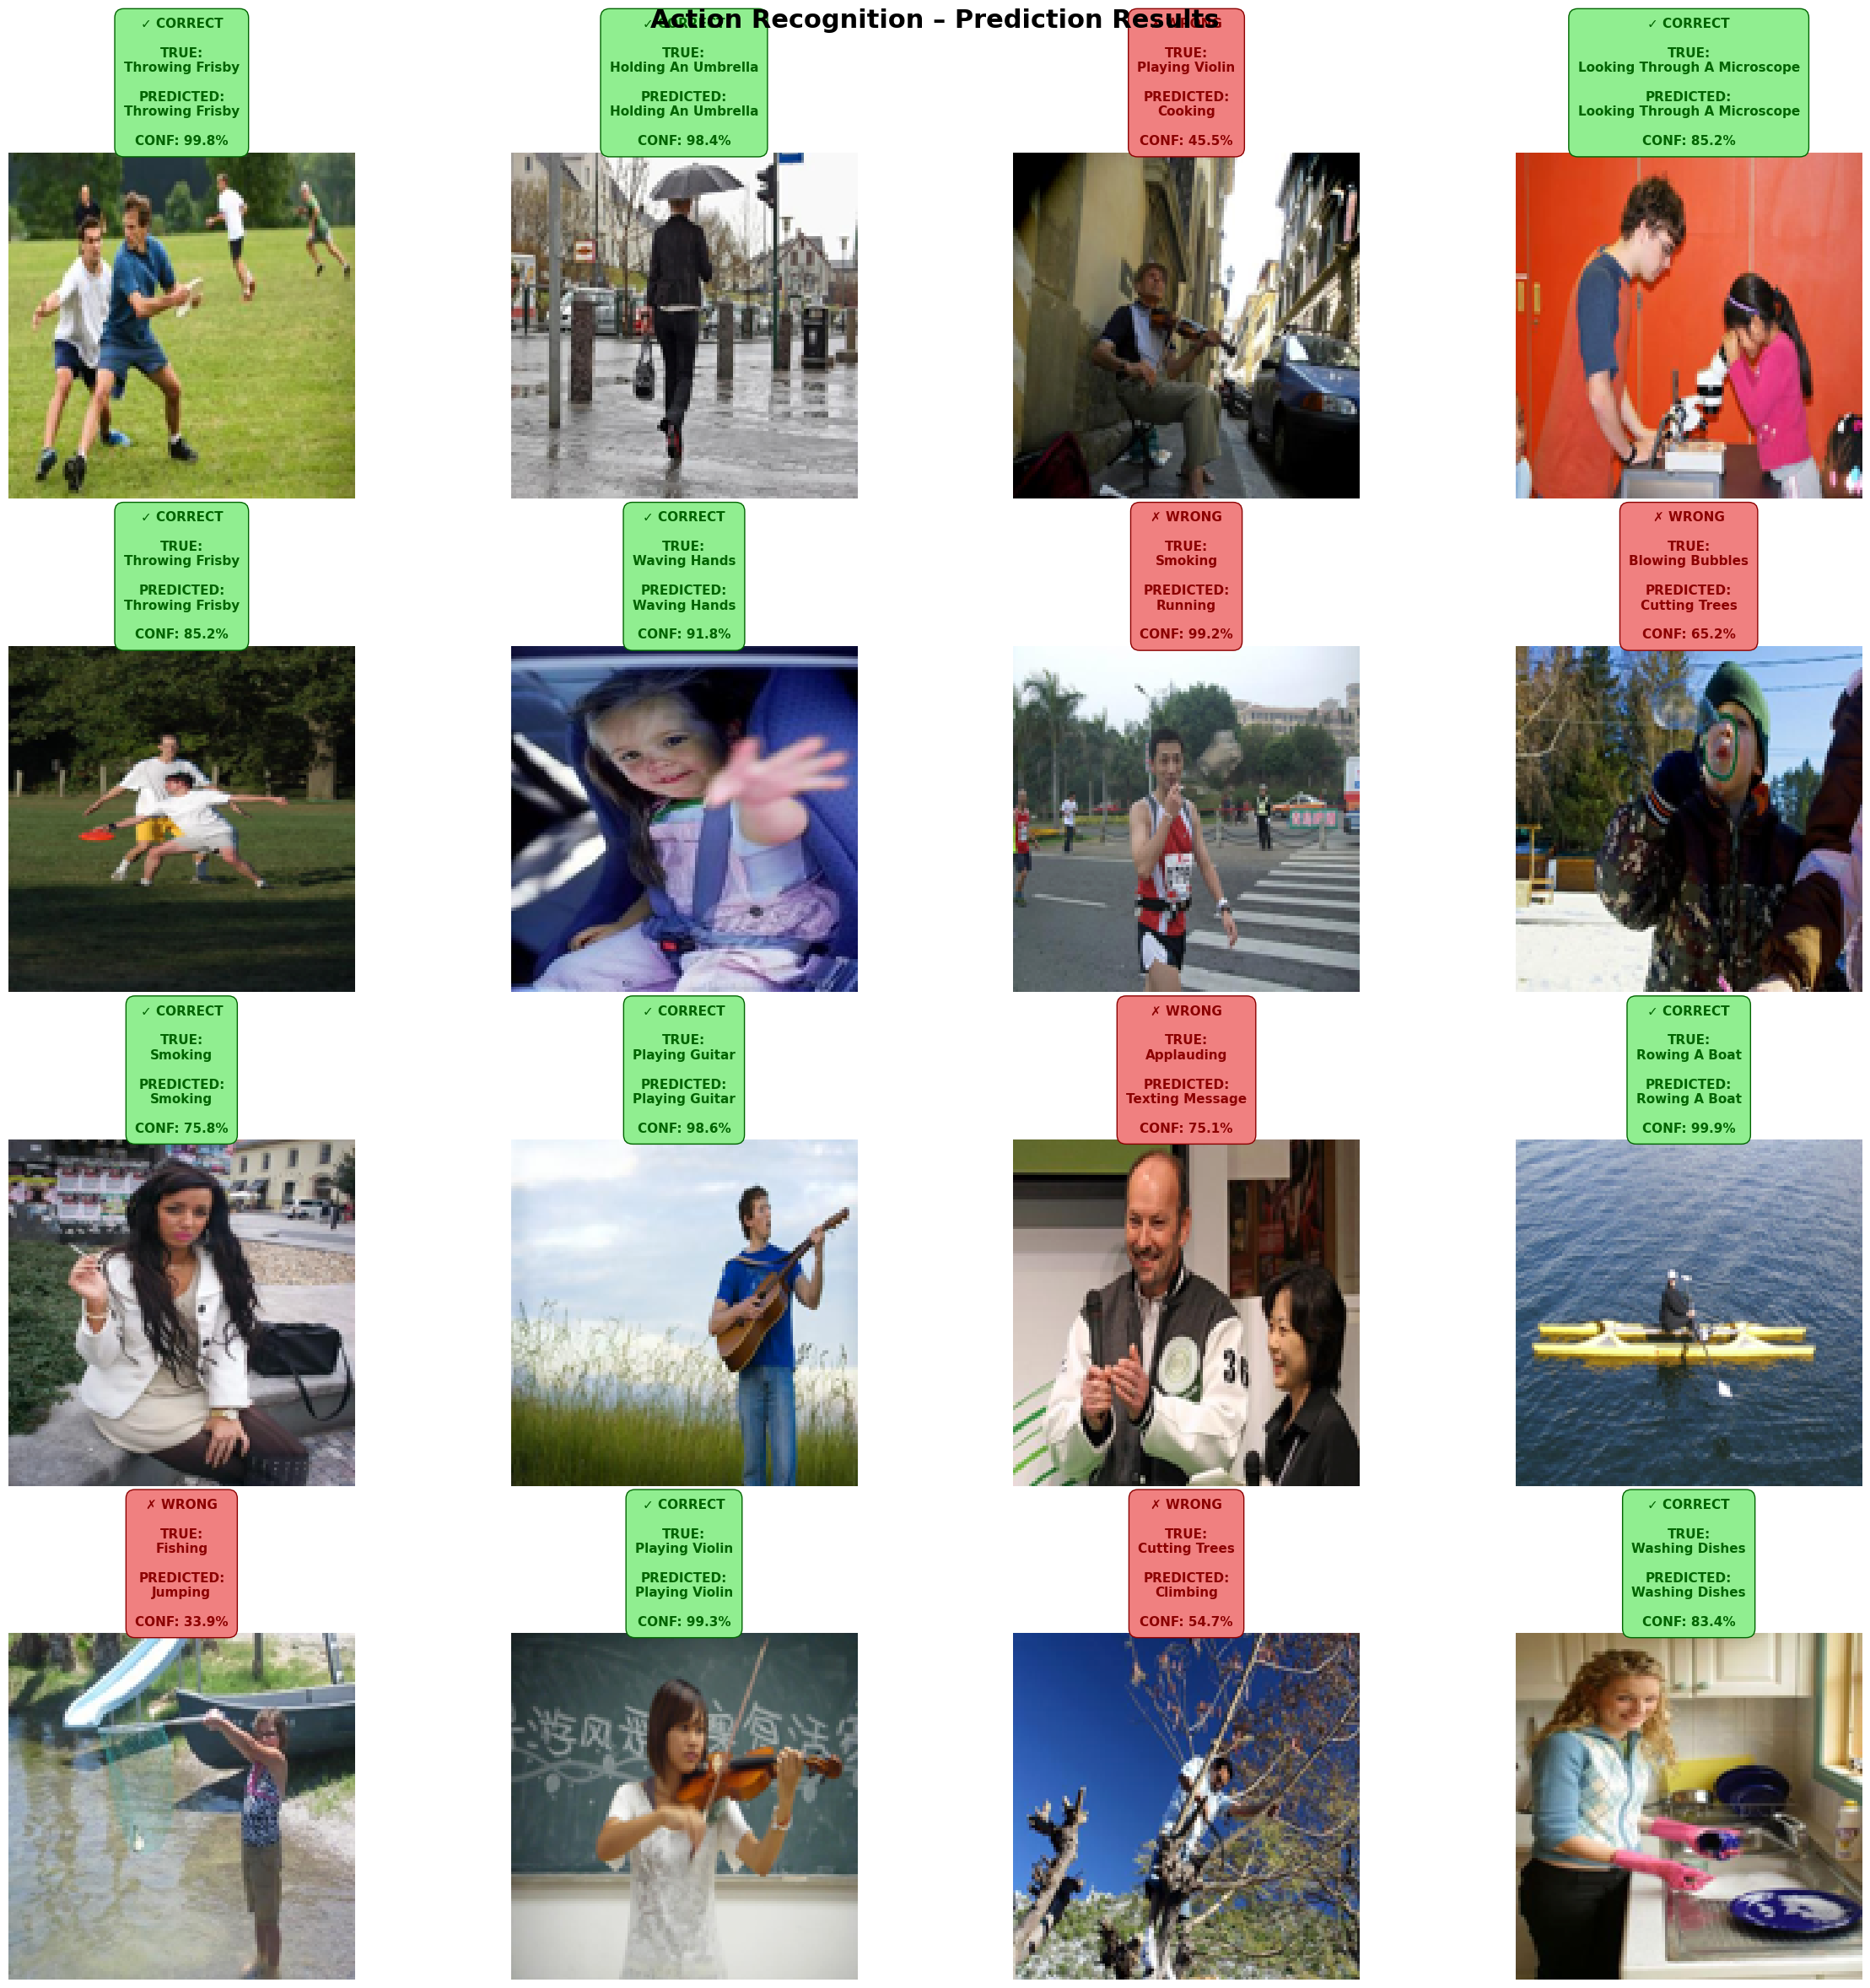


Detailed Top-5 Predictions


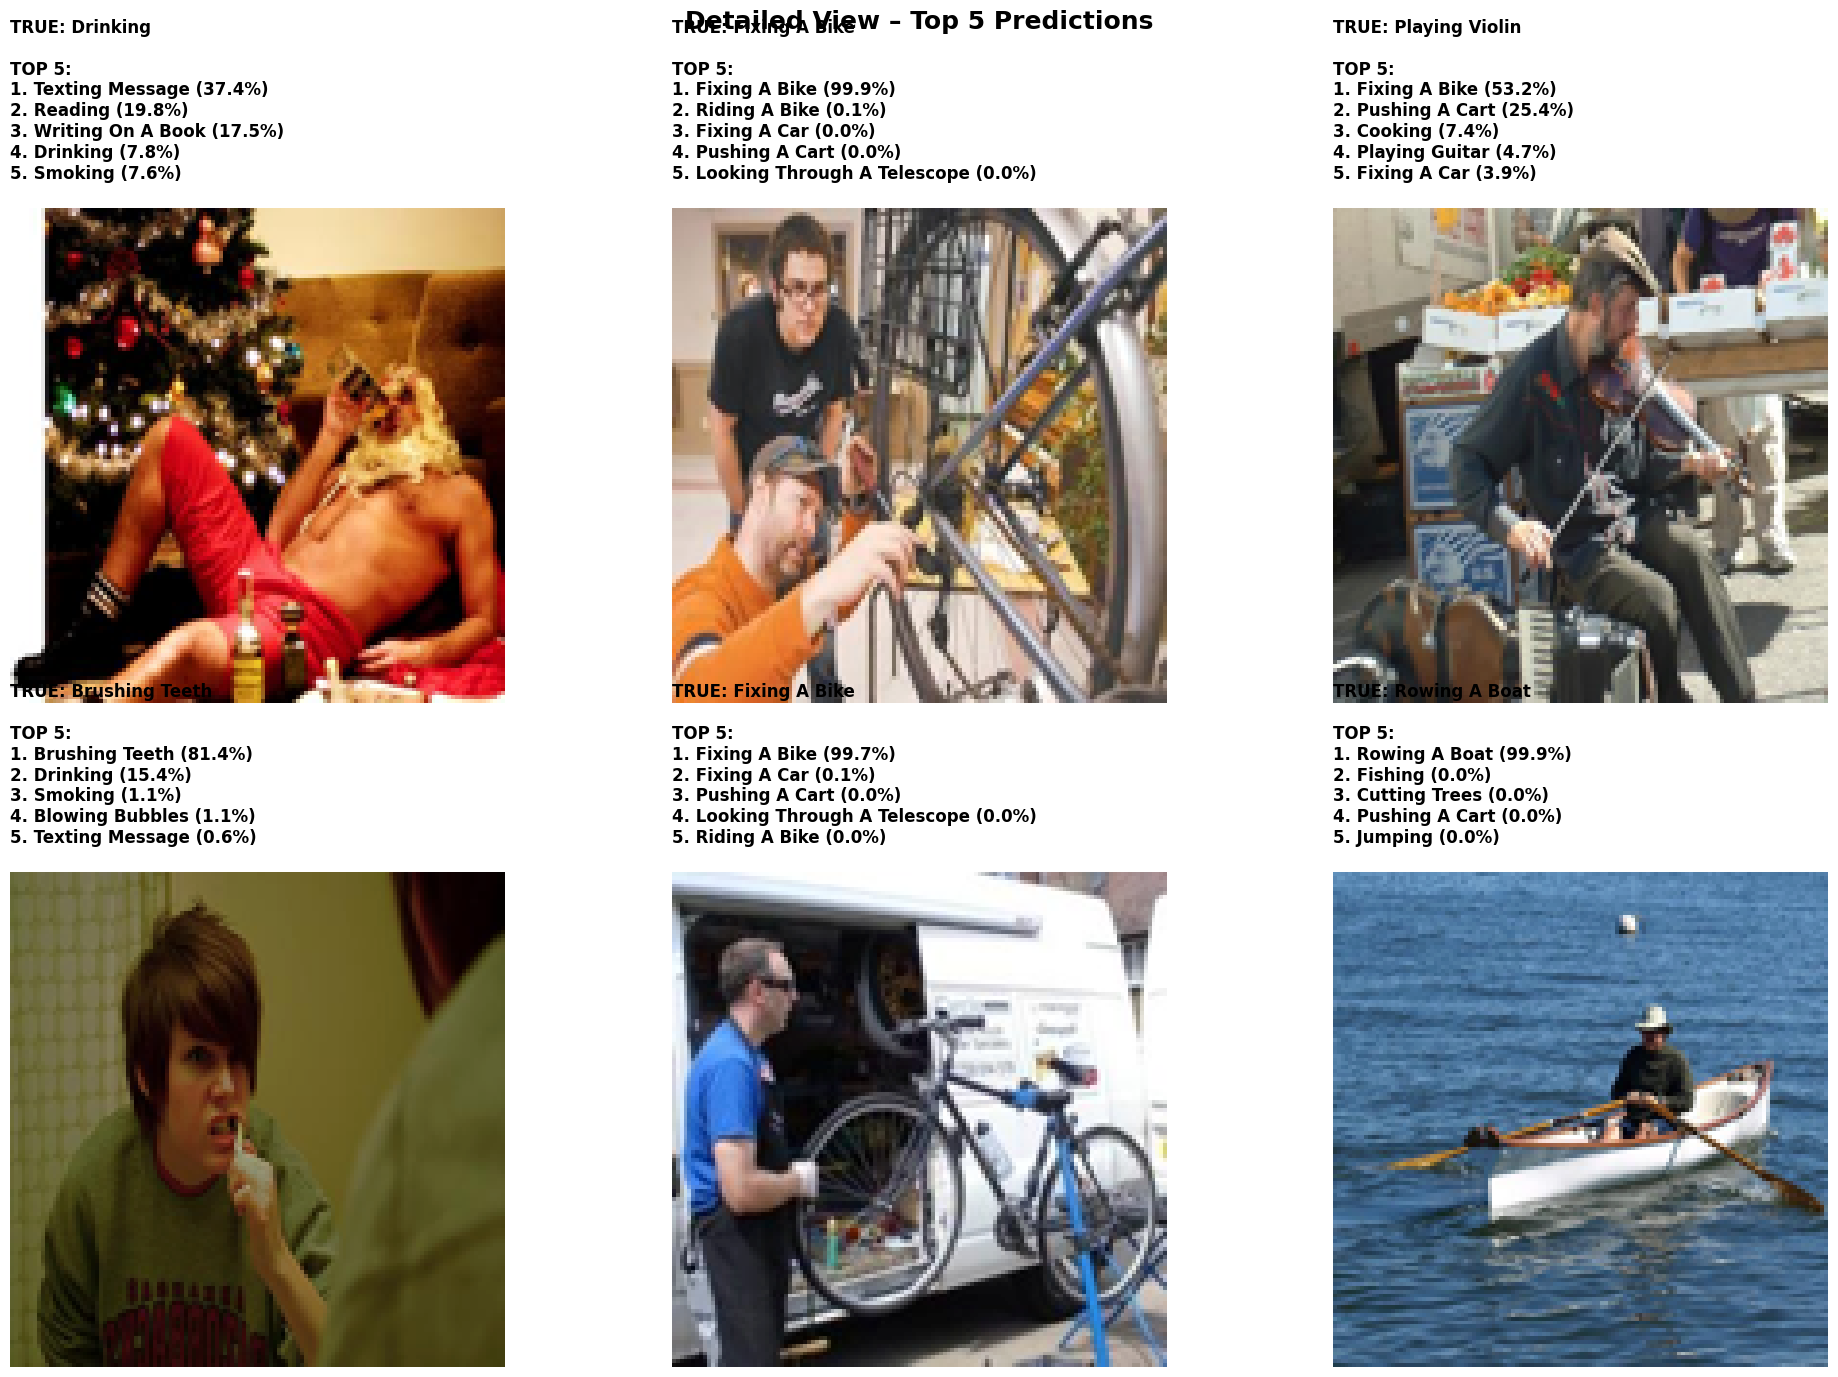


Generating confusion matrix...
Overall Accuracy: 61.78%


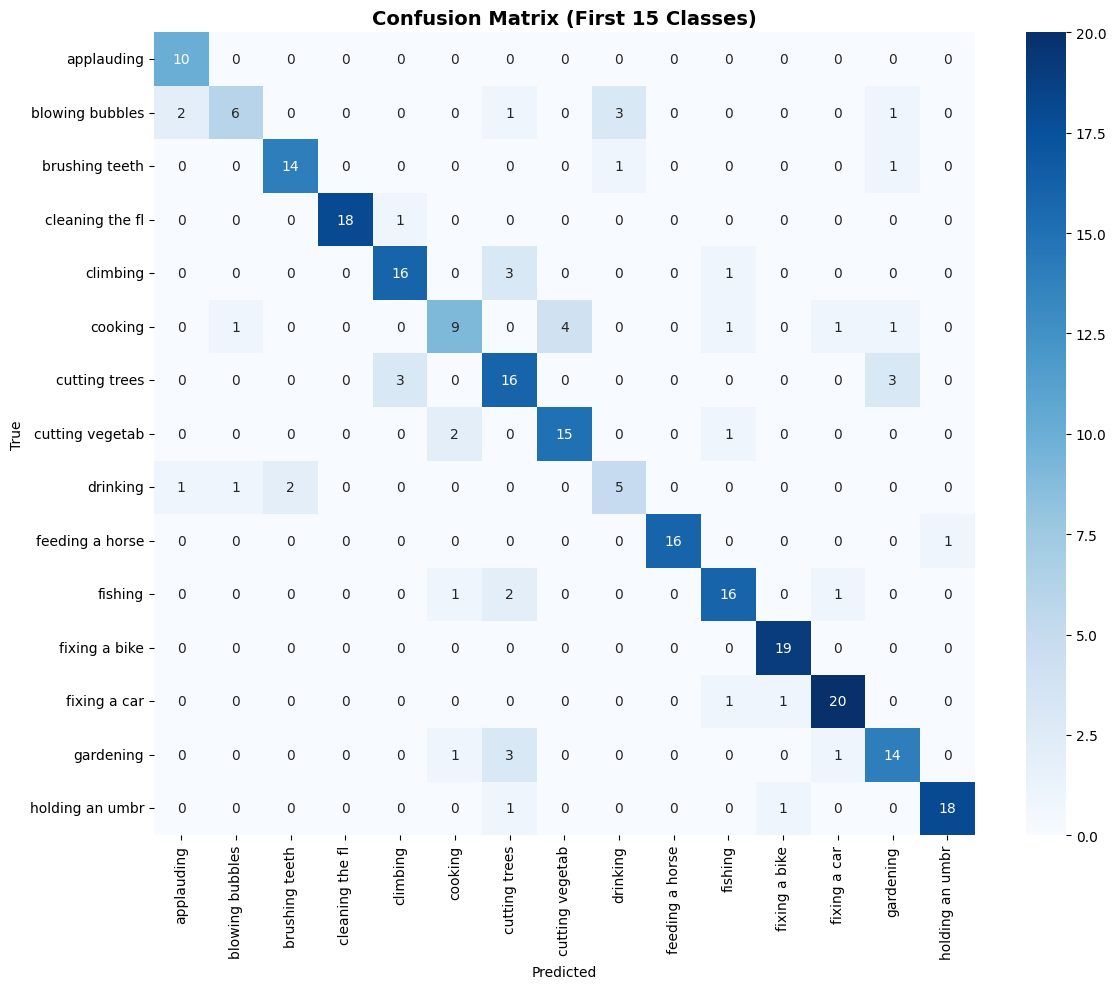


✅ Visualization complete! Images displayed and saved successfully.


In [10]:
"""
Visualization Only for Action Recognition
Loads trained model and visualizes predictions, top-5 results, and confusion matrix
"""

import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt
import gc

from sklearn.metrics import confusion_matrix
import seaborn as sns

# ===============================
# LOAD MODEL & DATA
# ===============================

print("Loading trained model...")
model = tf.keras.models.load_model('final_lightweight_model.h5')

print("Loading metadata...")
with open('dataset_metadata.json', 'r') as f:
    metadata = json.load(f)

class_names = metadata['classes']

print("Loading test data...")
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

print(f"Test samples: {len(X_test)}")

# ===============================
# IMAGE FIX (CRITICAL)
# ===============================

def fix_image(img):
    """
    Converts float16/float32 images to uint8 for matplotlib
    """
    img = img.astype(np.float32)
    if img.max() <= 1.0:
        img = img * 255.0
    return img.astype(np.uint8)

# ===============================
# VISUALIZE RANDOM PREDICTIONS
# ===============================

num_samples = 16
indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(24, 24))
axes = axes.ravel()

print("\n#  Status       True Action                    Predicted Action               Confidence")
print("=" * 95)

for i, idx in enumerate(indices):
    img_fixed = fix_image(X_test[idx])
    pred = model.predict(np.expand_dims(X_test[idx], axis=0), verbose=0)[0]

    pred_class = np.argmax(pred)
    confidence = pred[pred_class]
    true_class = y_test[idx]

    pred_action = class_names[pred_class].replace('_', ' ').title()
    true_action = class_names[true_class].replace('_', ' ').title()

    correct = pred_class == true_class
    status = "✓ CORRECT" if correct else "✗ WRONG"
    color = 'darkgreen' if correct else 'darkred'
    bg = 'lightgreen' if correct else 'lightcoral'

    axes[i].imshow(img_fixed)
    axes[i].axis('off')

    axes[i].set_title(
        f"{status}\n\nTRUE:\n{true_action}\n\nPREDICTED:\n{pred_action}\n\nCONF: {confidence*100:.1f}%",
        fontsize=11,
        weight='bold',
        color=color,
        bbox=dict(boxstyle='round,pad=0.7', facecolor=bg, edgecolor=color)
    )

    print(f"{i+1:<3} {status:<12} {true_action:<30} {pred_action:<30} {confidence*100:>6.1f}%")

plt.suptitle("Action Recognition – Prediction Results", fontsize=22, weight='bold')
plt.tight_layout()
plt.savefig("prediction_results.png", dpi=200, bbox_inches='tight')
plt.show()

# ===============================
# DETAILED TOP-5 PREDICTIONS
# ===============================

print("\nDetailed Top-5 Predictions")

detailed_indices = np.random.choice(len(X_test), 6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.ravel()

for i, idx in enumerate(detailed_indices):
    img_fixed = fix_image(X_test[idx])
    pred = model.predict(np.expand_dims(X_test[idx], axis=0), verbose=0)[0]

    top5 = np.argsort(pred)[-5:][::-1]
    true_class = y_test[idx]

    axes[i].imshow(img_fixed)
    axes[i].axis('off')

    title = f"TRUE: {class_names[true_class].replace('_',' ').title()}\n\nTOP 5:\n"
    for r, p in enumerate(top5, 1):
        title += f"{r}. {class_names[p].replace('_',' ').title()} ({pred[p]*100:.1f}%)\n"

    axes[i].set_title(title, fontsize=12, weight='bold', loc='left')

plt.suptitle("Detailed View – Top 5 Predictions", fontsize=18, weight='bold')
plt.tight_layout()
plt.savefig("top5_predictions.png", dpi=200, bbox_inches='tight')
plt.show()

# ===============================
# CONFUSION MATRIX
# ===============================

print("\nGenerating confusion matrix...")

y_pred = model.predict(X_test, batch_size=16, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = np.mean(y_pred_classes == y_test)
print(f"Overall Accuracy: {accuracy*100:.2f}%")

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm[:15, :15],
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[c.replace('_',' ')[:15] for c in class_names[:15]],
    yticklabels=[c.replace('_',' ')[:15] for c in class_names[:15]]
)
plt.title("Confusion Matrix (First 15 Classes)", fontsize=14, weight='bold')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150, bbox_inches='tight')
plt.show()

# ===============================
# CLEANUP
# ===============================

del X_test
gc.collect()

print("\n✅ Visualization complete! Images displayed and saved successfully.")
